# Intsall Package

In [2]:
# Install relevant packages, if not yet
!pip3 install awswrangler
!pip3 install pandasql
!pip3 install -U nltk
!pip3 install gensim
!pip3 install -U pip setuptools wheel
!pip3 install -U spacy
!python -m spacy download en_core_web_sm
!pip3 install statsmodels --upgrade
!pip install seaborn --upgrade

  Using cached awswrangler-2.17.0-py3-none-any.whl (251 kB)
  Using cached pyarrow-8.0.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (29.3 MB)
  Using cached backoff-2.2.1-py3-none-any.whl (15 kB)
  Using cached PyMySQL-1.0.2-py3-none-any.whl (43 kB)
  Using cached pg8000-1.29.2-py3-none-any.whl (34 kB)
  Using cached jsonpath_ng-1.5.3-py3-none-any.whl (29 kB)
  Using cached redshift_connector-2.0.909-py3-none-any.whl (112 kB)
  Using cached requests_aws4auth-1.1.2-py2.py3-none-any.whl (24 kB)
  Using cached gremlinpython-3.6.1-py2.py3-none-any.whl (73 kB)
  Using cached opensearch_py-2.0.0-py2.py3-none-any.whl (204 kB)
  Using cached isodate-0.6.1-py2.py3-none-any.whl (41 kB)
  Using cached aenum-3.1.11-py3-none-any.whl (131 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached scramp-1.4.1-py3-none-any.whl (8.5 kB)
  Using cached python_utils-3.3.3-py2.py3-none-any.whl (23 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.7/500.7 kB 5.

# Import Packages and Connect to RedShift

In [3]:
from data_connector import *
import numpy as np
import pandas as pd

In [4]:
# Fill in the relevant credentials for Redshift cluster(s) and S3 bucket(s) to use (credentials are hidden)
role_arn = ''
role_session_name = ''
secret_name = ''
dbname = ''
region_name = ''
bucket_name = ''
unload_iam_role = ''

In [5]:
# Initiate a connector object
redshift_s3_connect = RedshiftS3Connector(role_arn, role_session_name, secret_name, dbname, bucket_name, region_name, unload_iam_role)

# 1. Get the mellon_layer2.discussion_post table from Fall 2020 to Spring 2022

In [6]:
sc_query = f'''SELECT DISTINCT course_code, dept_name_abbrev FROM mellon_layer2.student_course 
WHERE term_desc in ('Fall 2020', 'Winter 2021', 'Spring 2021', 'Fall 2021', 'Winter 2022', 'Spring 2022');'''
sc = redshift_s3_connect.run_sql_command(sc_query)

Done waiting to finish Data API.
Status: FINISHED. Excution time: 35 miliseconds
{'ClusterIdentifier': 'uci-datalake-canvas-cluster-v1-redshiftcluster-a9h29wndif8j', 'CreatedAt': datetime.datetime(2022, 10, 6, 23, 10, 52, 125000, tzinfo=tzlocal()), 'Duration': 35848709, 'HasResultSet': True, 'Id': '24f95ab5-57e0-4b75-8331-1d359ffb6db5', 'QueryString': "SELECT DISTINCT course_code, dept_name_abbrev FROM mellon_layer2.student_course \nWHERE term_desc in ('Fall 2020', 'Winter 2021', 'Spring 2021', 'Fall 2021', 'Winter 2022', 'Spring 2022');", 'RedshiftPid': 1084370232, 'RedshiftQueryId': 7349609, 'ResultRows': 15195, 'ResultSize': 251677, 'SecretArn': 'arn:aws:secretsmanager:us-west-2:848271137894:secret:Redshift-DLL-Sagemaker-Secret-nHWV37', 'Status': 'FINISHED', 'UpdatedAt': datetime.datetime(2022, 10, 6, 23, 10, 52, 702000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '4d7fe7d1-c00a-4aa6-8017-516b56f8c0a5', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '4d7fe7d1-c0

In [25]:
sc[['course_code', 'dept_name_abbrev']].nunique()

course_code         15161
dept_name_abbrev      104
dtype: int64

In [26]:
sc.loc[sc['dept_name_abbrev'] == '', 'dept_name_abbrev'].count()

0

In [6]:
get_df_query = f'''
WITH roster AS
         (SELECT DISTINCT mellon_id,
                          sis_term_code,
                          instruc_begins::DATE,
                          (instruc_ends::DATE + 9) AS final_ends,
                          canvas_course_id,
                          sis_course_code
          FROM mellon_layer2.enrollment er
                   LEFT JOIN mellon_layer2.term_dates td ON er.sis_term_code = td.term_desc
          WHERE is_valid_user
            AND is_valid_course_section
            AND enrollment_type = \\'StudentEnrollment\\')
SELECT dp.*, rs.sis_term_code AS term, st.citizenship_app AS citizenship, rs.sis_course_code
FROM mellon_layer2.v_discussion_post AS dp 
INNER JOIN roster rs
                ON dp.canvas_course_id = rs.canvas_course_id AND dp.mellon_id = rs.mellon_id
INNER JOIN mellon_layer2.student st 
                ON dp.mellon_id = st.mellon_id
WHERE CONVERT_TIMEZONE(\\'PST\\', dp.discussion_post_created_at) BETWEEN \\'2020-10-01 00:00:00\\' AND \\'2022-06-10 00:00:00\\' 
AND CONVERT_TIMEZONE(\\'PST\\', dp.discussion_post_created_at) BETWEEN rs.instruc_begins AND rs.final_ends
AND dp.discussion_post_deleted_at IS NULL;'''
print(get_df_query)


WITH roster AS
         (SELECT DISTINCT mellon_id,
                          sis_term_code,
                          instruc_begins::DATE,
                          (instruc_ends::DATE + 9) AS final_ends,
                          canvas_course_id,
                          sis_course_code
          FROM mellon_layer2.enrollment er
                   LEFT JOIN mellon_layer2.term_dates td ON er.sis_term_code = td.term_desc
          WHERE is_valid_user
            AND is_valid_course_section
            AND enrollment_type = \'StudentEnrollment\')
SELECT dp.*, rs.sis_term_code AS term, st.citizenship_app AS citizenship, rs.sis_course_code
FROM mellon_layer2.v_discussion_post AS dp 
INNER JOIN roster rs
                ON dp.canvas_course_id = rs.canvas_course_id AND dp.mellon_id = rs.mellon_id
INNER JOIN mellon_layer2.student st 
                ON dp.mellon_id = st.mellon_id
WHERE CONVERT_TIMEZONE(\'PST\', dp.discussion_post_created_at) BETWEEN \'2020-10-01 00:00:00\' AND \'2022-06-

In [6]:
file_in_s3 = 'discussion_post_LDA.csv'

In [8]:
redshift_s3_connect.unload_from_redshift_to_s3(get_df_query, file_in_s3, 'csv')

Waiter DataAPIExecution failed: Max attempts exceeded
Status: STARTED. Excution time: 0 miliseconds
{'ClusterIdentifier': 'uci-datalake-canvas-cluster-v1-redshiftcluster-a9h29wndif8j', 'CreatedAt': datetime.datetime(2022, 10, 2, 3, 46, 24, 304000, tzinfo=tzlocal()), 'Duration': -1, 'HasResultSet': False, 'Id': 'cee8ca02-8e7f-462a-96f1-0aaf1fec695b', 'QueryString': "UNLOAD ('\nWITH roster AS\n         (SELECT DISTINCT mellon_id,\n                          sis_term_code,\n                          instruc_begins::DATE,\n                          (instruc_ends::DATE + 9) AS final_ends,\n                          canvas_course_id,\n                          sis_course_code\n          FROM mellon_layer2.enrollment er\n                   LEFT JOIN mellon_layer2.term_dates td ON er.sis_term_code = td.term_desc\n          WHERE is_valid_user\n            AND is_valid_course_section\n            AND enrollment_type = \\'StudentEnrollment\\')\nSELECT dp.*, rs.sis_term_code AS term, st.citizenshi

In [7]:
file_names = [file_in_s3]
file_type = 'csv'
discussion_post = redshift_s3_connect.read_from_s3(file_names, file_type)
discussion_post

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,discussion_post_updated_at,discussion_post_deleted_at,discussion_post_depth,parent_discussion_post_id,discussion_topic_id,...,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,sis_course_code
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-03-01 07:36:52.865,2022-03-01 07:36:52.865,NaN,1,NaN,679184,...,0.000404,0.000404,0.000404,0.000404,0.115502,0.000404,0.030095,0.000404,0.218273,12080
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-10 05:06:35.605,2022-03-10 05:06:35.605,NaN,1,NaN,679190,...,0.000606,0.000606,0.000606,0.000606,0.000606,0.000606,0.144997,0.000606,0.090478,12080
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-03 07:35:35.021,2022-03-03 07:35:35.021,NaN,1,NaN,679186,...,0.000430,0.000430,0.000430,0.000430,0.105291,0.000430,0.102069,0.000430,0.000430,12080
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-22 07:06:58.18,2022-02-22 07:06:58.18,NaN,1,NaN,679178,...,0.000473,0.000473,0.000473,0.000473,0.274186,0.237333,0.134962,0.000473,0.000473,12080
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-23 02:45:06.688,2021-01-23 02:45:06.688,NaN,1,NaN,464333,...,0.002083,0.002083,0.002083,0.002083,0.002083,0.757963,0.002083,0.214954,0.002083,62110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168339,3976802,174455,36826,<p>I loved your presentation! In terms of bupe...,2021-04-17 05:14:42.667,2021-04-17 05:14:42.667,NaN,2,3958952.0,537648,...,0.004167,0.004167,0.004167,0.004167,0.004167,0.221790,0.004167,0.267110,0.004167,88522
1168340,3975548,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-17 02:40:07.184,2021-04-17 02:40:07.184,NaN,3,3964734.0,537648,...,0.002667,0.002667,0.380535,0.002667,0.002667,0.002667,0.342473,0.002667,0.002667,88522
1168341,3982902,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-18 22:13:38.639,2021-04-18 22:13:38.639,NaN,3,3967451.0,537648,...,0.002469,0.002469,0.064244,0.096122,0.090050,0.002469,0.002469,0.002469,0.406295,88522
1168342,3849145,171666,35994,"<p>According to google, the Universe is 13.8 b...",2021-03-30 18:10:15.886,2021-03-30 18:10:15.886,NaN,1,NaN,520693,...,0.002667,0.002667,0.072958,0.002667,0.002667,0.002667,0.002667,0.002667,0.002667,47400


In [143]:
topic_cols = [f'Topic{i}' for i in range(15)]

In [176]:
df = discussion_post.loc[:, ['discussion_post_id', 'mellon_id', 'canvas_course_id', 'discussion_post_content', 'discussion_post_created_at', 'parent_discussion_post_id', 'discussion_topic_id', 'discussion_topic_created_at', 'discussion_topic_posted_at', 'term', 'citizenship', 'sis_course_code']+topic_cols]
#df = df = discussion_post.loc[:, ['discussion_post_id', 'mellon_id', 'canvas_course_id', 'discussion_post_content', 'discussion_post_created_at', 'parent_discussion_post_id', 'discussion_topic_id', 'discussion_topic_created_at', 'discussion_topic_posted_at', 'term', 'citizenship']]
df.loc[df['discussion_topic_posted_at'].isna(), 'discussion_topic_posted_at'] = df.loc[df['discussion_topic_posted_at'].isna(), 'discussion_topic_created_at']

In [177]:
# Not necessary if not need department for the course
df = df.merge(sc, how='left', left_on='sis_course_code', right_on='course_code')

In [76]:
df.loc[df['dept_name_abbrev'].isna(), ['canvas_course_id', 'course_code']]

,canvas_course_id,course_code
4101,33913,NaN
4102,33913,NaN
5390,40128,NaN
5391,40128,NaN
16825,28741,NaN
...,...,...
1201589,28741,NaN
1201590,28741,NaN
1201591,28741,NaN
1201592,28741,NaN


In [62]:
df.loc[temp['course_code'].isna(), 'canvas_course_id'].nunique()

10

In [178]:
df = df.drop_duplicates(subset='discussion_post_id')
df.loc[df['dept_name_abbrev'].isna(), 'dept_name_abbrev'] = 'UNKNOWN'
df = df.reset_index(drop=True)

In [12]:
df['dept_name_abbrev'].nunique()

85

In [179]:
df

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_created_at,discussion_topic_posted_at,term,...,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,course_code,dept_name_abbrev
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-03-01 07:36:52.865,NaN,679184,2022-01-10 17:53:50.198,2022-01-10 17:53:50.198,Winter 2022,...,0.000404,0.000404,0.000404,0.115502,0.000404,0.030095,0.000404,0.218273,12080.0,EDUC
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-10 05:06:35.605,NaN,679190,2022-01-10 17:54:41.292,2022-01-10 17:54:41.293,Winter 2022,...,0.000606,0.000606,0.000606,0.000606,0.000606,0.144997,0.000606,0.090478,12080.0,EDUC
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-03 07:35:35.021,NaN,679186,2022-01-10 17:54:11.739,2022-01-10 17:54:11.74,Winter 2022,...,0.000430,0.000430,0.000430,0.105291,0.000430,0.102069,0.000430,0.000430,12080.0,EDUC
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-22 07:06:58.18,NaN,679178,2022-01-10 17:53:18.992,2022-01-10 17:53:18.992,Winter 2022,...,0.000473,0.000473,0.000473,0.274186,0.237333,0.134962,0.000473,0.000473,12080.0,EDUC
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-23 02:45:06.688,NaN,464333,2020-12-25 01:04:31.718,2020-12-25 01:04:31.72,Winter 2021,...,0.002083,0.002083,0.002083,0.002083,0.757963,0.002083,0.214954,0.002083,62110.0,ECON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168339,3976802,174455,36826,<p>I loved your presentation! In terms of bupe...,2021-04-17 05:14:42.667,3958952.0,537648,2021-03-30 13:32:43.564,2021-04-11 23:58:50.802,Spring 2021,...,0.004167,0.004167,0.004167,0.004167,0.221790,0.004167,0.267110,0.004167,88522.0,PHRMSCI
1168340,3975548,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-17 02:40:07.184,3964734.0,537648,2021-03-30 13:32:43.564,2021-04-11 23:58:50.802,Spring 2021,...,0.002667,0.380535,0.002667,0.002667,0.002667,0.342473,0.002667,0.002667,88522.0,PHRMSCI
1168341,3982902,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-18 22:13:38.639,3967451.0,537648,2021-03-30 13:32:43.564,2021-04-11 23:58:50.802,Spring 2021,...,0.002469,0.064244,0.096122,0.090050,0.002469,0.002469,0.002469,0.406295,88522.0,PHRMSCI
1168342,3849145,171666,35994,"<p>According to google, the Universe is 13.8 b...",2021-03-30 18:10:15.886,NaN,520693,2021-03-18 19:15:34.624,2021-03-23 23:51:26.375,Spring 2021,...,0.002667,0.072958,0.002667,0.002667,0.002667,0.002667,0.002667,0.002667,47400.0,PHYSICS


In [148]:
# Get the students posted in each quarter
s1 = df.loc[df['term'] == 'Fall 2020', 'mellon_id'].drop_duplicates()
s2 = df.loc[df['term'] == 'Winter 2021', 'mellon_id'].drop_duplicates()
s3 = df.loc[df['term'] == 'Spring 2021', 'mellon_id'].drop_duplicates()
s4 = df.loc[df['term'] == 'Fall 2021', 'mellon_id'].drop_duplicates()
s5 = df.loc[df['term'] == 'Winter 2022', 'mellon_id'].drop_duplicates()
s6 = df.loc[df['term'] == 'Spring 2022', 'mellon_id'].drop_duplicates()
id_lst = [s1, s2, s3, s4, s5, s6]

In [149]:
# the df that only contains the posts from students who posted in all 6 quarters
for d in id_lst:
    df = df.merge(d, how='inner', on='mellon_id')

In [150]:
df['mellon_id'].nunique()

1705

In [37]:
# Number of foreign students that posted in all 6 quarters
df.loc[df['citizenship'] == 'Not US Citizen', 'mellon_id'].nunique()

312

In [38]:
df.loc[df['citizenship'] != 'Not US Citizen', 'mellon_id'].nunique()

1393

In [11]:
df['mellon_id'].nunique()

20629

In [13]:
df.groupby(by='term')['mellon_id'].nunique().reset_index(name='student_cnt')

,term,student_cnt
0,Fall 2020,15597
1,Fall 2021,8138
2,Spring 2021,12887
3,Spring 2022,5863
4,Winter 2021,13948
5,Winter 2022,6707


In [50]:
df.groupby(by='citizenship')['mellon_id'].nunique()

citizenship
Not US Citizen            3308
Permanent Resident        1587
US Citizen                  23
US Citizen in Transit    15578
Name: mellon_id, dtype: int64

In [51]:
df.groupby(by='term')['discussion_post_id'].size().reset_index(name='num_of_posts')

,term,num_of_posts
0,Fall 2020,300551
1,Fall 2021,140963
2,Spring 2021,250647
3,Spring 2022,91394
4,Winter 2021,268359
5,Winter 2022,116430


# 2. Preprocess the data

## 2.1 Clean the data

In [13]:
import online_discourse_analysis as oda
import numpy as np
import pandas as pd

In [16]:
df = oda.discussion_text_clean(df)

In [ ]:
df.head(2)

## 2.2 Transfer the UTC timestamp to Pacific timestamp

In [180]:
df = oda.utc_to_pts(df)

In [137]:
df.head(3)

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_created_at,discussion_topic_posted_at,term,...,Topic11,Topic12,Topic13,Topic14,course_code,dept_name_abbrev,discussion_topic_post_time_gap,Analytic,Tone,cogproc
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-02-28 23:36:52.865000-08:00,NaN,679184,2022-01-10 17:53:50.198,2022-01-10 09:53:50.198000-08:00,Winter 2022,...,0.000404,0.030095,0.000404,0.218273,12080.0,EDUC,4.0,1.0,3.0,2.0
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-09 21:06:35.605000-08:00,NaN,679190,2022-01-10 17:54:41.292,2022-01-10 09:54:41.293000-08:00,Winter 2022,...,0.000606,0.144997,0.000606,0.090478,12080.0,EDUC,3.0,2.0,6.0,6.0
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-02 23:35:35.021000-08:00,NaN,679186,2022-01-10 17:54:11.739,2022-01-10 09:54:11.740000-08:00,Winter 2022,...,0.000430,0.102069,0.000430,0.000430,12080.0,EDUC,7.0,3.0,1.0,2.0


# 3. Calculate and Standardize Behavioral Features and LIWC Outputs

In [181]:
df = oda.discussion_topic_post_time_gap(df)

In [132]:
df.head()

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_created_at,discussion_topic_posted_at,term,...,Topic11,Topic12,Topic13,Topic14,course_code,dept_name_abbrev,discussion_topic_post_time_gap,Analytic,Tone,cogproc
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-02-28 23:36:52.865000-08:00,NaN,679184,2022-01-10 17:53:50.198,2022-01-10 09:53:50.198000-08:00,Winter 2022,...,0.000404,0.030095,0.000404,0.218273,12080.0,EDUC,4.0,1.0,3.0,2.0
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-09 21:06:35.605000-08:00,NaN,679190,2022-01-10 17:54:41.292,2022-01-10 09:54:41.293000-08:00,Winter 2022,...,0.000606,0.144997,0.000606,0.090478,12080.0,EDUC,3.0,2.0,6.0,6.0
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-02 23:35:35.021000-08:00,NaN,679186,2022-01-10 17:54:11.739,2022-01-10 09:54:11.740000-08:00,Winter 2022,...,0.000430,0.102069,0.000430,0.000430,12080.0,EDUC,7.0,3.0,1.0,2.0
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-21 23:06:58.180000-08:00,NaN,679178,2022-01-10 17:53:18.992,2022-01-10 09:53:18.992000-08:00,Winter 2022,...,0.237333,0.134962,0.000473,0.000473,12080.0,EDUC,9.0,8.0,9.0,4.0
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-22 18:45:06.688000-08:00,NaN,464333,2020-12-25 01:04:31.718,2020-12-24 17:04:31.720000-08:00,Winter 2021,...,0.757963,0.002083,0.214954,0.002083,62110.0,ECON,45.0,29.0,14.0,9.0


In [16]:
LIWC_file = ['LIWC2015 Results (discussion_id_content.csv).csv']
df_LIWC = redshift_s3_connect.read_from_s3(LIWC_file, 'csv')
df_LIWC

/opt/conda/lib/python3.7/site-packages/awswrangler/s3/_read_text.py:156: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  path=paths[0], version_id=version_id[paths[0]] if isinstance(version_id, dict) else version_id, **args


,A,B,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,discussion_post_id,discussion_post_content,3,93.26,99.00,98.01,25.77,3.00,66.67,66.67,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,66.67
1,5127365,<p>I found the reading for this week's discuss...,434,53.90,50.92,68.92,51.65,31.00,25.81,90.78,...,0.92,0.0,0.23,0.00,0.00,0.46,0.00,1.38,0.0,1.38
2,5165138,<p>This week's reading from Florez discusses w...,284,33.89,87.02,26.62,77.59,28.40,18.31,90.49,...,0.70,0.0,0.70,0.00,0.00,0.70,0.00,1.41,0.0,2.46
3,5135831,<p>Gilliam's reading for this week placed an e...,369,67.40,72.44,35.06,3.09,33.55,26.83,87.53,...,1.63,0.0,0.27,0.00,0.00,0.00,0.54,1.08,0.0,1.63
4,5094972,<p>I found De Sousa's reading very impactful a...,351,71.24,80.35,25.74,82.05,35.10,26.21,85.19,...,0.85,0.0,0.28,0.00,0.00,0.00,0.00,0.85,0.0,1.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168340,3976802,<p>I loved your presentation! In terms of bupe...,51,85.92,65.27,53.79,62.94,17.00,17.65,76.47,...,1.96,0.0,1.96,3.92,1.96,0.00,0.00,0.00,0.0,11.76
1168341,3975548,"<p>Hello,</p>\n<p>So the main reason that pati...",78,51.25,50.00,1.00,73.64,26.00,30.77,75.64,...,3.85,0.0,1.28,0.00,0.00,0.00,2.56,0.00,0.0,15.38
1168342,3982902,"<p>Hello,</p>\n<p>So the main reason that pati...",113,46.65,39.52,34.35,25.77,28.25,27.43,76.99,...,5.31,0.0,1.77,0.00,0.00,0.00,0.00,0.88,0.0,10.62
1168343,3849145,"<p>According to google, the Universe is 13.8 b...",77,95.35,60.26,24.62,25.77,25.67,16.88,55.84,...,3.90,0.0,2.60,0.00,0.00,0.00,0.00,0.00,0.0,24.68


In [17]:
df_LIWC = df_LIWC.drop(0).rename(columns = {'A':'discussion_post_id','B':'discussion_post_content'})

In [18]:
df_LIWC = df_LIWC.loc[:, ['discussion_post_id', 'Analytic', 'Tone', 'cogproc']]

In [19]:
df_LIWC['discussion_post_id'] = df_LIWC['discussion_post_id'].astype(int)

In [182]:
df = df.merge(df_LIWC, how='inner', on='discussion_post_id')
df

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_created_at,discussion_topic_posted_at,term,...,Topic11,Topic12,Topic13,Topic14,course_code,dept_name_abbrev,discussion_topic_post_time_gap,Analytic,Tone,cogproc
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-02-28 23:36:52.865000-08:00,NaN,679184,2022-01-10 17:53:50.198,2022-01-10 09:53:50.198000-08:00,Winter 2022,...,0.000404,0.030095,0.000404,0.218273,12080.0,EDUC,49.571559,53.90,51.65,12.67
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-09 21:06:35.605000-08:00,NaN,679190,2022-01-10 17:54:41.292,2022-01-10 09:54:41.293000-08:00,Winter 2022,...,0.000606,0.144997,0.000606,0.090478,12080.0,EDUC,58.466601,33.89,77.59,14.08
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-02 23:35:35.021000-08:00,NaN,679186,2022-01-10 17:54:11.739,2022-01-10 09:54:11.740000-08:00,Winter 2022,...,0.000430,0.102069,0.000430,0.000430,12080.0,EDUC,51.570408,67.40,3.09,11.11
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-21 23:06:58.180000-08:00,NaN,679178,2022-01-10 17:53:18.992,2022-01-10 09:53:18.992000-08:00,Winter 2022,...,0.237333,0.134962,0.000473,0.000473,12080.0,EDUC,42.551148,71.24,82.05,11.40
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-22 18:45:06.688000-08:00,NaN,464333,2020-12-25 01:04:31.718,2020-12-24 17:04:31.720000-08:00,Winter 2021,...,0.757963,0.002083,0.214954,0.002083,62110.0,ECON,29.069849,89.86,55.05,9.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168339,3976802,174455,36826,<p>I loved your presentation! In terms of bupe...,2021-04-16 22:14:42.667000-07:00,3958952.0,537648,2021-03-30 13:32:43.564,2021-04-11 16:58:50.802000-07:00,Spring 2021,...,0.221790,0.004167,0.267110,0.004167,88522.0,PHRMSCI,5.219350,85.92,62.94,5.88
1168340,3975548,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-16 19:40:07.184000-07:00,3964734.0,537648,2021-03-30 13:32:43.564,2021-04-11 16:58:50.802000-07:00,Spring 2021,...,0.002667,0.342473,0.002667,0.002667,88522.0,PHRMSCI,5.111995,51.25,73.64,24.36
1168341,3982902,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-18 15:13:38.639000-07:00,3967451.0,537648,2021-03-30 13:32:43.564,2021-04-11 16:58:50.802000-07:00,Spring 2021,...,0.002469,0.002469,0.002469,0.406295,88522.0,PHRMSCI,6.926943,46.65,25.77,18.58
1168342,3849145,171666,35994,"<p>According to google, the Universe is 13.8 b...",2021-03-30 11:10:15.886000-07:00,NaN,520693,2021-03-18 19:15:34.624,2021-03-23 16:51:26.375000-07:00,Spring 2021,...,0.002667,0.002667,0.002667,0.002667,47400.0,PHYSICS,6.763073,95.35,25.77,5.19


In [154]:
cols = ['discussion_topic_post_time_gap', 'Analytic', 'Tone', 'cogproc']

In [155]:
df_st = oda.standardized_score(df, cols)
df_st

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_created_at,discussion_topic_posted_at,term,...,Topic11,Topic12,Topic13,Topic14,course_code,dept_name_abbrev,discussion_topic_post_time_gap,Analytic,Tone,cogproc
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-02-28 23:36:52.865000-08:00,NaN,679184,2022-01-10 17:53:50.198,2022-01-10 09:53:50.198000-08:00,Winter 2022,...,0.000404,0.030095,0.000404,0.218273,12080.0,EDUC,1.000000,0.333333,1.000000,0.333333
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-09 21:06:35.605000-08:00,NaN,679190,2022-01-10 17:54:41.292,2022-01-10 09:54:41.293000-08:00,Winter 2022,...,0.000606,0.144997,0.000606,0.090478,12080.0,EDUC,0.500000,0.250000,0.750000,0.750000
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-02 23:35:35.021000-08:00,NaN,679186,2022-01-10 17:54:11.739,2022-01-10 09:54:11.740000-08:00,Winter 2022,...,0.000430,0.102069,0.000430,0.000430,12080.0,EDUC,0.750000,0.500000,0.250000,0.500000
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-21 23:06:58.180000-08:00,NaN,679178,2022-01-10 17:53:18.992,2022-01-10 09:53:18.992000-08:00,Winter 2022,...,0.237333,0.134962,0.000473,0.000473,12080.0,EDUC,1.000000,0.750000,0.500000,0.250000
4,4452380,185484,40438,<p>Hi everyone!</p>\n<p>My name is Alexandra M...,2021-09-30 20:39:45.850000-07:00,NaN,611563,2021-09-19 21:46:58.331,2021-09-19 14:46:58.331000-07:00,Fall 2021,...,0.001667,0.001667,0.001667,0.028205,70112.0,SOCSCI,0.666667,0.333333,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232499,4845511,170209,42293,<p>Hello fellow classmates!&nbsp;</p>\n<p>My n...,2022-01-06 14:13:52.181000-08:00,NaN,667981,2021-12-29 23:24:37.259,2021-12-29 15:24:37.259000-08:00,Winter 2022,...,0.000717,0.115773,0.024870,0.059686,69430.0,SOCIOL,0.540230,0.436782,0.137931,0.597701
232500,3649641,170209,32872,<p>Does anyone know how to find the probabilit...,2021-02-11 18:56:49.683000-08:00,NaN,456716,2020-12-11 06:30:30.335,2021-02-06 00:00:05.398000-08:00,Winter 2021,...,0.007407,0.007407,0.007408,0.007407,37030.0,STATS,0.500000,1.000000,0.500000,1.000000
232501,3439764,170209,32872,<p>Hello! </p>\n<p>My name is Emily Miramontes...,2021-01-12 09:33:01.305000-08:00,NaN,464958,2020-12-28 01:46:02.385,2020-12-27 17:53:49.674000-08:00,Winter 2021,...,0.003333,0.122445,0.003333,0.003333,37030.0,STATS,0.800000,0.400000,0.600000,0.800000
232502,3457695,170209,32872,"<p>Hi Amanda, </p>\n<p>Monica and I formed a g...",2021-01-14 10:31:23.635000-08:00,3439764.0,464958,2020-12-28 01:46:02.385,2020-12-27 17:53:49.674000-08:00,Winter 2021,...,0.009524,0.009524,0.009524,0.009524,37030.0,STATS,1.000000,0.600000,0.800000,0.400000


# Aggregate the variables at student-course level

In [183]:
df_st_avg = oda.calculate_features_avg(df_st, cols)
df_st_post_cnt_avg = oda.discussion_post_count(df_st)
df_avg = oda.calculate_features_avg(df, cols)
df_post_cnt_avg = oda.discussion_post_count(df)

In [184]:
df_avg = df_avg.merge(df_post_cnt_avg, how='left', on=['term', 'mellon_id', 'canvas_course_id'])
df_avg = df_avg.merge(df[['term', 'mellon_id', 'canvas_course_id', 'citizenship', 'dept_name_abbrev']].drop_duplicates(), 
                      how='left', on=['term', 'mellon_id', 'canvas_course_id'])
df_st_avg = df_st_avg.merge(df_st_post_cnt_avg, how='left', on=['term', 'mellon_id', 'canvas_course_id'])
df_st_avg = df_st_avg.merge(df_st[['term', 'mellon_id', 'canvas_course_id', 'citizenship', 'dept_name_abbrev']].drop_duplicates(), 
                      how='left', on=['term', 'mellon_id', 'canvas_course_id'])

In [185]:
cols_avg = ['discussion_topic_post_time_gap_avg', 'Analytic_avg', 'Tone_avg', 'cogproc_avg', 'discussion_post_cnt_avg']

In [159]:
df_foreign = df_st_avg.loc[df_st_avg['citizenship'] == 'Not US Citizen']
df_US = df_st_avg.loc[df_st_avg['citizenship'] != 'Not US Citizen']

In [160]:
df_foreign_term_avg = df_foreign.groupby(by='term')[cols_avg].mean().reset_index()
df_US_term_avg = df_US.groupby(by='term')[cols_avg].mean().reset_index()

In [161]:
term_order = ['Fall 2020', 'Winter 2021', 'Spring 2021', 'Fall 2021', 'Winter 2022', 'Spring 2022']

In [162]:
df_foreign_term_avg = df_foreign_term_avg.set_index('term').loc[term_order].reset_index()
df_US_term_avg = df_US_term_avg.set_index('term').loc[term_order].reset_index()

In [163]:
df_US_term_avg

,term,discussion_topic_post_time_gap_avg,Analytic_avg,Tone_avg,cogproc_avg,discussion_post_cnt_avg
0,Fall 2020,0.614295,0.605826,0.576246,0.598292,11.599310
1,Winter 2021,0.607680,0.597934,0.574703,0.594114,12.639012
2,Spring 2021,0.607455,0.601191,0.574347,0.600691,12.318047
3,Fall 2021,0.603066,0.588501,0.560222,0.583224,12.765813
4,Winter 2022,0.598409,0.585304,0.557059,0.581818,12.324434
5,Spring 2022,0.599652,0.583195,0.553376,0.583014,11.751099


In [164]:
df_foreign_term_avg

,term,discussion_topic_post_time_gap_avg,Analytic_avg,Tone_avg,cogproc_avg,discussion_post_cnt_avg
0,Fall 2020,0.629173,0.608903,0.563883,0.581779,12.223388
1,Winter 2021,0.622489,0.619258,0.549493,0.580894,12.350820
2,Spring 2021,0.642831,0.629679,0.579102,0.610126,11.540404
3,Fall 2021,0.619227,0.621937,0.567552,0.599335,11.316476
4,Winter 2022,0.616929,0.633016,0.575845,0.598120,12.229130
5,Spring 2022,0.625345,0.635336,0.563157,0.585182,10.834879


In [165]:
df_foreign_term_avg.iloc[:, 1:] - df_US_term_avg.iloc[:, 1:]

,discussion_topic_post_time_gap_avg,Analytic_avg,Tone_avg,cogproc_avg,discussion_post_cnt_avg
0,0.014878,0.003077,-0.012362,-0.016514,0.624078
1,0.014809,0.021324,-0.025211,-0.013220,-0.288192
2,0.035376,0.028488,0.004755,0.009434,-0.777643
3,0.016161,0.033436,0.007330,0.016110,-1.449336
4,0.018519,0.047712,0.018786,0.016302,-0.095304
5,0.025693,0.052142,0.009781,0.002167,-0.916220


# Trend Visualization

In [30]:
import matplotlib.pyplot as plt

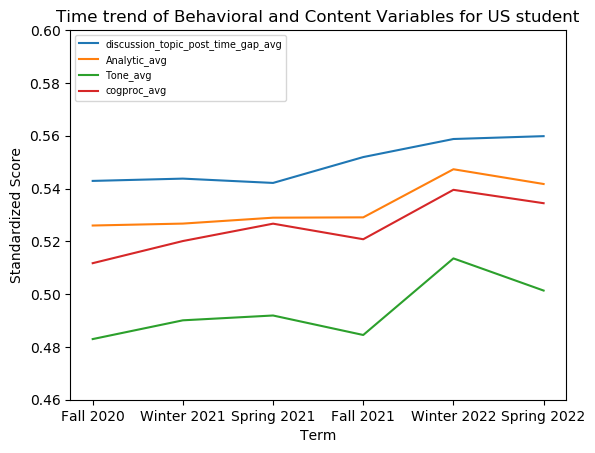

In [68]:
# Trend (standardized variables) for US student
fig, ax = plt.subplots()
for col in df_US_term_avg.columns:
    if col not in ['discussion_post_cnt_avg', 'term']:
        ax.plot(df_US_term_avg['term'], df_US_term_avg[col], label=col)
        
ax.legend(loc = 'upper left', fontsize='x-small')
ax.set_xlabel('Term')
ax.set_ylabel('Standardized Score')
ax.set_ylim(0.46, 0.6)
ax.set_title('Time trend of Behavioral and Content Variables for US student')
plt.show()

In [69]:
fig.savefig('Trend_Stand_US.png')

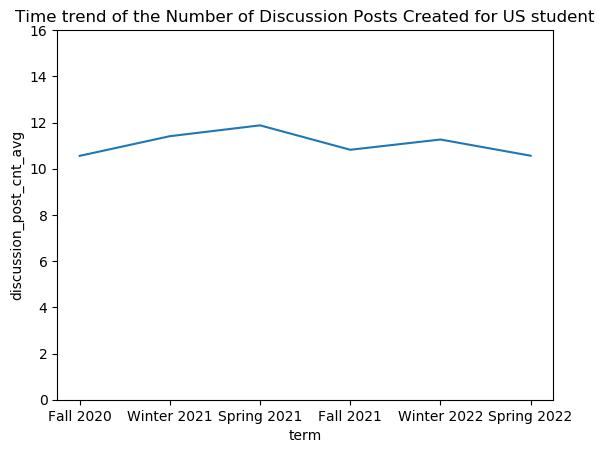

In [79]:
# Trend (num of discussion posts) for US student
fig, ax = plt.subplots()
ax.plot(df_US_term_avg['term'], df_US_term_avg['discussion_post_cnt_avg'])
ax.set_title('Time trend of the Number of Discussion Posts Created for US student')
ax.set_ylim(0, 16)
ax.set_xlabel('term')
ax.set_ylabel('discussion_post_cnt_avg')
plt.show()

In [81]:
fig.savefig('Trend_num_posts_US.png')

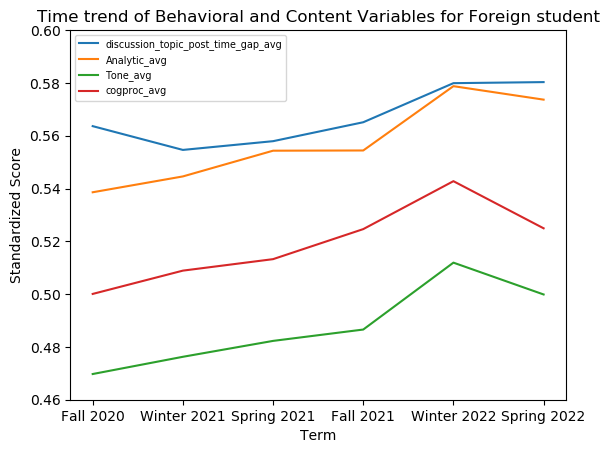

In [73]:
# Trend (standardized variables) for foreign student
fig, ax = plt.subplots()
for col in df_foreign_term_avg.columns:
    if col not in ['discussion_post_cnt_avg', 'term']:
        ax.plot(df_foreign_term_avg['term'], df_foreign_term_avg[col], label=col)
        
ax.legend(loc = 'upper left', fontsize='x-small')
ax.set_xlabel('Term')
ax.set_ylabel('Standardized Score')
ax.set_ylim(0.46, 0.6)
ax.set_title('Time trend of Behavioral and Content Variables for Foreign student')
plt.show()

In [74]:
fig.savefig('Trend_Stand_foreign.png')

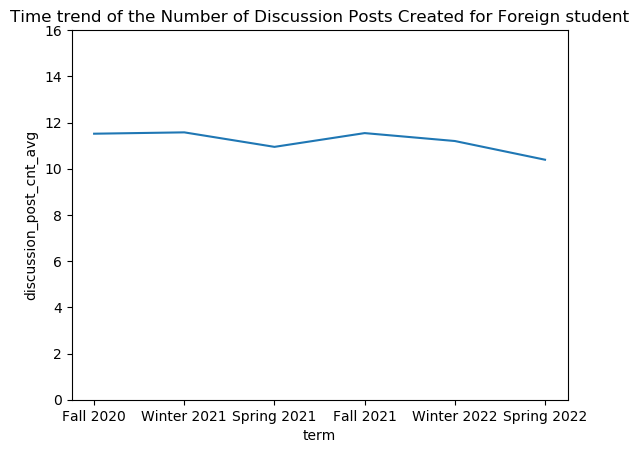

In [82]:
# Trend (num of discussion posts) for foreign student
fig, ax = plt.subplots()
ax.plot(df_foreign_term_avg['term'], df_foreign_term_avg['discussion_post_cnt_avg'])
ax.set_title('Time trend of the Number of Discussion Posts Created for Foreign student')
ax.set_ylim(0, 16)
ax.set_xlabel('term')
ax.set_ylabel('discussion_post_cnt_avg')
plt.show()

In [83]:
fig.savefig('Trend_num_posts_foreign.png')

# Trend and Difference

In [58]:
!pip3 install --upgrade scipy

In [189]:
df_avg['term_code'] = df_avg.apply(lambda row: oda.term_code(row), axis=1)

In [190]:
df_avg

,term,mellon_id,canvas_course_id,discussion_topic_post_time_gap_avg,Analytic_avg,Tone_avg,cogproc_avg,discussion_post_cnt_avg,citizenship,dept_name_abbrev,term_code
0,Fall 2020,162766,29291,55.598314,64.445000,45.021000,13.206000,20,Permanent Resident,ART,1
1,Fall 2020,162766,30152,0.620807,95.240000,71.550000,2.440000,1,Permanent Resident,SOCIOL,1
2,Fall 2020,162766,30507,4.850920,79.656154,50.553077,14.069231,13,Permanent Resident,SOCIOL,1
3,Fall 2020,162766,31325,6.728204,74.745000,29.005000,11.105000,4,Permanent Resident,DRAMA,1
4,Fall 2020,162766,31360,1.326873,3.683333,33.000000,4.763333,3,Permanent Resident,PHILOS,1
...,...,...,...,...,...,...,...,...,...,...,...
104756,Winter 2022,428917,43127,18.953163,83.816667,38.746667,16.725000,6,US Citizen in Transit,PHILOS,5
104757,Winter 2022,430426,43531,19.846661,63.022500,85.642500,13.222500,4,Not US Citizen,ACENG,5
104758,Winter 2022,430426,43913,1.102179,95.585000,25.770000,18.780000,2,Not US Citizen,ACENG,5
104759,Winter 2022,431714,42306,28.904419,32.580000,25.770000,21.210000,1,Permanent Resident,BIOSCI,5


## GLS for Trend

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [191]:
# include interaction term (term:dept)
for col in cols_avg:
    print('    ' + col + ':')
    formula = f'{col} ~ term_code + term_code:dept_name_abbrev'
    model = smf.gls(formula, data=df_avg).fit()

    print(model.summary())
    print()

    discussion_topic_post_time_gap_avg:
                                    GLS Regression Results                                    
Dep. Variable:     discussion_topic_post_time_gap_avg   R-squared:                       0.143
Model:                                            GLS   Adj. R-squared:                  0.142
Method:                                 Least Squares   F-statistic:                     205.8
Date:                                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                                        06:04:35   Log-Likelihood:            -4.6565e+05
No. Observations:                              104761   AIC:                         9.315e+05
Df Residuals:                                  104675   BIC:                         9.323e+05
Df Model:                                          85                                         
Covariance Type:                            nonrobust                                         
          

In [168]:
# No include interaction term (term:dept)
for col in cols_avg:
    print('    ' + col + ':')
    x = df_avg['term_code']
    y = df_avg[col]
    x = sm.add_constant(x)
    model = sm.GLSAR(y, x, 1).fit()
    print(model.summary())
    print()

    discussion_topic_post_time_gap_avg:
                                   GLSAR Regression Results                                   
Dep. Variable:     discussion_topic_post_time_gap_avg   R-squared:                       0.010
Model:                                          GLSAR   Adj. R-squared:                  0.010
Method:                                 Least Squares   F-statistic:                     186.8
Date:                                Fri, 07 Oct 2022   Prob (F-statistic):           2.52e-42
Time:                                        05:52:25   Log-Likelihood:                -81439.
No. Observations:                               19145   AIC:                         1.629e+05
Df Residuals:                                   19143   BIC:                         1.629e+05
Df Model:                                           1                                         
Covariance Type:                            nonrobust                                         
          

## t-test for Fall 2020

In [169]:
for col in cols_avg:
    print(f't-test for {col}:')
    print(oda.t_test_group('Fall 2020', df_US, df_foreign, col))
    print()

t-test for discussion_topic_post_time_gap_avg:
Ttest_indResult(statistic=-1.5614850303018977, pvalue=0.11849811335735388)

t-test for Analytic_avg:
Ttest_indResult(statistic=-0.3706668718169735, pvalue=0.7109076901238847)

t-test for Tone_avg:
Ttest_indResult(statistic=1.5050849156698802, pvalue=0.13239083539021304)

t-test for cogproc_avg:
Ttest_indResult(statistic=1.9630209663745195, pvalue=0.049721376404461046)

t-test for discussion_post_cnt_avg:
Ttest_indResult(statistic=-1.3741633671129918, pvalue=0.16947735401235214)



## t-test for Winter 2021

In [170]:
for col in cols_avg:
    print(f't-test for {col}:')
    print(oda.t_test_group('Winter 2021', df_US, df_foreign, col))
    print()

t-test for discussion_topic_post_time_gap_avg:
Ttest_indResult(statistic=-1.4656198378823444, pvalue=0.14284658029501499)

t-test for Analytic_avg:
Ttest_indResult(statistic=-2.485528280552149, pvalue=0.012984791588779415)

t-test for Tone_avg:
Ttest_indResult(statistic=3.079435574198174, pvalue=0.0020908943388761817)

t-test for cogproc_avg:
Ttest_indResult(statistic=1.5494052530304216, pvalue=0.12137964468233055)

t-test for discussion_post_cnt_avg:
Ttest_indResult(statistic=0.6019185971814515, pvalue=0.5472694259569022)



## t-test for Spring 2021

In [171]:
for col in cols_avg:
    print(f't-test for {col}:')
    print(oda.t_test_group('Spring 2021', df_US, df_foreign, col))
    print()

t-test for discussion_topic_post_time_gap_avg:
Ttest_indResult(statistic=-3.4671561104223354, pvalue=0.0005327244386781181)

t-test for Analytic_avg:
Ttest_indResult(statistic=-3.265370217931165, pvalue=0.0011043941489411587)

t-test for Tone_avg:
Ttest_indResult(statistic=-0.5722956371304426, pvalue=0.5671607362424276)

t-test for cogproc_avg:
Ttest_indResult(statistic=-1.1078565737241683, pvalue=0.2680046005728148)

t-test for discussion_post_cnt_avg:
Ttest_indResult(statistic=1.730267747142003, pvalue=0.08367605308640627)



## t-test for Fall 2021

In [172]:
for col in cols_avg:
    print(f't-test for {col}:')
    print(oda.t_test_group('Fall 2021', df_US, df_foreign, col))
    print()

t-test for discussion_topic_post_time_gap_avg:
Ttest_indResult(statistic=-1.592199653761819, pvalue=0.11144151080834087)

t-test for Analytic_avg:
Ttest_indResult(statistic=-3.7580136190785867, pvalue=0.00017441408878440394)

t-test for Tone_avg:
Ttest_indResult(statistic=-0.8268333789250062, pvalue=0.40839496030314637)

t-test for cogproc_avg:
Ttest_indResult(statistic=-1.8415568232922186, pvalue=0.06563520320401528)

t-test for discussion_post_cnt_avg:
Ttest_indResult(statistic=3.140133488577409, pvalue=0.0017045588823508232)



## t-test for Winter 2022

In [173]:
for col in cols_avg:
    print(f't-test for {col}:')
    print(oda.t_test_group('Winter 2022', df_US, df_foreign, col))
    print()

t-test for discussion_topic_post_time_gap_avg:
Ttest_indResult(statistic=-1.765044258716601, pvalue=0.07765694733945964)

t-test for Analytic_avg:
Ttest_indResult(statistic=-5.363346825366292, pvalue=8.783070389577004e-08)

t-test for Tone_avg:
Ttest_indResult(statistic=-2.1904766712428407, pvalue=0.028565555307794716)

t-test for cogproc_avg:
Ttest_indResult(statistic=-1.8604832490007888, pvalue=0.06291390224785046)

t-test for discussion_post_cnt_avg:
Ttest_indResult(statistic=0.18456479393040257, pvalue=0.8535827410949979)



## t-test for Spring 2022

In [175]:
for col in cols_avg:
    print(f't-test for {col}:')
    print(oda.t_test_group('Spring 2022', df_US, df_foreign, col))
    print()

t-test for discussion_topic_post_time_gap_avg:
Ttest_indResult(statistic=-2.3007551911447104, pvalue=0.021478341199905136)

t-test for Analytic_avg:
Ttest_indResult(statistic=-5.38329333562362, pvalue=7.916630884364539e-08)

t-test for Tone_avg:
Ttest_indResult(statistic=-1.0305829376253546, pvalue=0.3028251033520344)

t-test for cogproc_avg:
Ttest_indResult(statistic=-0.22469841982579258, pvalue=0.8222302255185798)

t-test for discussion_post_cnt_avg:
Ttest_indResult(statistic=1.9563948800761672, pvalue=0.05051753913636524)



# Analyze Reply Rates

In [85]:
df_reply = oda.discussion_reply_rate(df)

In [70]:
def international(row):
    if row['citizenship'] == 'Not US Citizen':
        return 1
    else:
        return 0

In [86]:
df_reply['international'] = df_reply.apply(func=lambda r: international(r), axis=1)

In [94]:
df_reply

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id_x,discussion_topic_id,discussion_topic_created_at,discussion_topic_posted_at,term,...,Topic14,course_code,dept_name_abbrev,discussion_topic_post_time_gap,Analytic,Tone,cogproc,parent_discussion_post_id_y,reply_rate,international
0,3847462,180283,36509,<p>Hey everyone! I'm a 2nd year majoring in Ed...,2021-03-30 00:47:51.502000-07:00,NaN,531000,2021-03-26 20:33:50.943,2021-03-26 13:33:50.943000-07:00,Spring 2021,...,0.002381,50040.0,SOCECOL,39.0,136.0,105.0,93.0,3847462.0,1,0
1,4091662,180283,36509,<p><span>I agree with Veenhoven’s&nbsp;critici...,2021-05-06 19:01:12.473000-07:00,NaN,530971,2021-03-26 20:33:48.899,2021-03-26 13:33:48.899000-07:00,Spring 2021,...,0.001212,50040.0,SOCECOL,68.0,109.0,58.0,104.0,4091662.0,1,0
2,4173140,180283,36509,<p>Although most philosophers did not explicit...,2021-05-20 21:16:13.472000-07:00,NaN,530966,2021-03-26 20:33:48.561,2021-03-26 13:33:48.561000-07:00,Spring 2021,...,0.001418,50040.0,SOCECOL,83.0,88.0,61.0,108.0,4173140.0,1,0
3,3897120,180283,36509,"<p>Hi Babak, this was an interesting take on t...",2021-04-06 02:22:22.314000-07:00,3894065.0,530994,2021-03-26 20:33:50.541,2021-03-26 13:33:50.541000-07:00,Spring 2021,...,0.110904,50040.0,SOCECOL,13.0,43.0,35.0,56.0,3897120.0,1,0
4,4012677,180283,36509,"<p>During the college decision process, some i...",2021-04-22 23:21:50.594000-07:00,NaN,530980,2021-03-26 20:33:49.64,2021-03-26 13:33:49.640000-07:00,Spring 2021,...,0.206634,50040.0,SOCECOL,111.0,51.0,70.0,53.0,4012677.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223818,4256072,174455,36826,<p>Wonderful presentation 10B! You mentioned t...,2021-06-05 11:01:23.623000-07:00,4241099.0,537633,2021-03-30 13:32:38.444,2021-05-31 18:24:29.398000-07:00,Spring 2021,...,0.005556,88522.0,PHRMSCI,149.0,26.0,134.0,222.0,4256072.0,2,0
223819,4256059,174455,36826,<p>Great Presentation 10A! In terms of Nirapar...,2021-06-05 10:54:09.952000-07:00,4239356.0,537633,2021-03-30 13:32:38.444,2021-05-31 18:24:29.398000-07:00,Spring 2021,...,0.009524,88522.0,PHRMSCI,147.0,84.0,172.0,162.0,4256059.0,1,0
223820,4256065,174455,36826,"<p>Hey 10C! I loved your presentation, in term...",2021-06-05 10:57:40.544000-07:00,4240938.0,537633,2021-03-30 13:32:38.444,2021-05-31 18:24:29.398000-07:00,Spring 2021,...,0.003333,88522.0,PHRMSCI,148.0,43.0,22.0,53.0,4256065.0,1,0
223821,4170711,174455,36826,<p>Great presentation 8A! I had a question reg...,2021-05-20 15:19:11.965000-07:00,4166130.0,537639,2021-03-30 13:32:40.527,2021-05-17 14:37:34.582000-07:00,Spring 2021,...,0.005128,88522.0,PHRMSCI,17.0,51.0,70.0,10.0,4170711.0,1,0


## Linear Regression

In [65]:
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

In [87]:
cols = ['discussion_topic_post_time_gap', 'international']

In [88]:
x = df_reply[cols + topic_cols]
y = df_reply['reply_rate']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             reply_rate   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     155.7
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        02:26:28   Log-Likelihood:            -4.1394e+05
No. Observations:              223823   AIC:                         8.279e+05
Df Residuals:                  223806   BIC:                         8.281e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [97]:
# errors
error = model.params - model.conf_int()[0]

In [98]:
error

const                             0.008944
discussion_topic_post_time_gap    0.000096
international                     0.017743
Topic0                            0.064868
Topic1                            0.052678
Topic2                            0.035822
Topic3                            0.040358
Topic4                            0.061037
Topic5                            0.067343
Topic6                            0.069562
Topic7                            0.083481
Topic8                            0.054552
Topic9                            0.068347
Topic10                           0.038103
Topic11                           0.067517
Topic12                           0.053856
Topic13                           0.059917
Topic14                           0.051521
dtype: float64

In [99]:
# df for coefficients and standard errors
coef_err_df = pd.DataFrame({'coef' : model.params.values[1:],
                           'error' : error.values[1:],
                           'varname' : error.index.values[1:]})

In [100]:
coef_err_df

,coef,error,varname
0,-0.001498,0.000096,discussion_topic_post_time_gap
1,0.005657,0.017743,international
2,-0.278787,0.064868,Topic0
3,0.254034,0.052678,Topic1
4,0.248942,0.035822,Topic2
5,-0.101017,0.040358,Topic3
6,-0.004093,0.061037,Topic4
7,0.560855,0.067343,Topic5
8,-0.202869,0.069562,Topic6
9,0.558285,0.083481,Topic7


In [101]:
full_topic_names = ['T0: Race and Crime', 'T1: Philosophy', 'T2: Remote Learning', 'T3: Common Words',
                    'T4: Community Resource', 'T5: Film Arts and Technology', 'T6: Gender Differences in Substance Use',
                    'T7: Free Chat / Short Response', 'T8: Mental Health during Covid-19 Pandemic', 
                    'T9: Problems in Work', 'T10: Resources for Students\' Study and Research', 'T11: Writing',
                    'T12: Family Interaction', 'T13: Business', 'T14: The Medium of the Government and the Public in Social Issues']

In [102]:
coef_err_df.loc[2:, 'varname'] = full_topic_names
coef_err_df = coef_err_df[::-1]
coef_err_df

,coef,error,varname
16,0.050130,0.051521,T14: The Medium of the Government and the Publ...
15,-0.134631,0.059917,T13: Business
14,-0.134658,0.053856,T12: Family Interaction
13,0.560571,0.067517,T11: Writing
12,-0.030401,0.038103,T10: Resources for Students' Study and Research
11,0.569251,0.068347,T9: Problems in Work
10,-0.217098,0.054552,T8: Mental Health during Covid-19 Pandemic
9,0.558285,0.083481,T7: Free Chat / Short Response
8,-0.202869,0.069562,T6: Gender Differences in Substance Use
7,0.560855,0.067343,T5: Film Arts and Technology


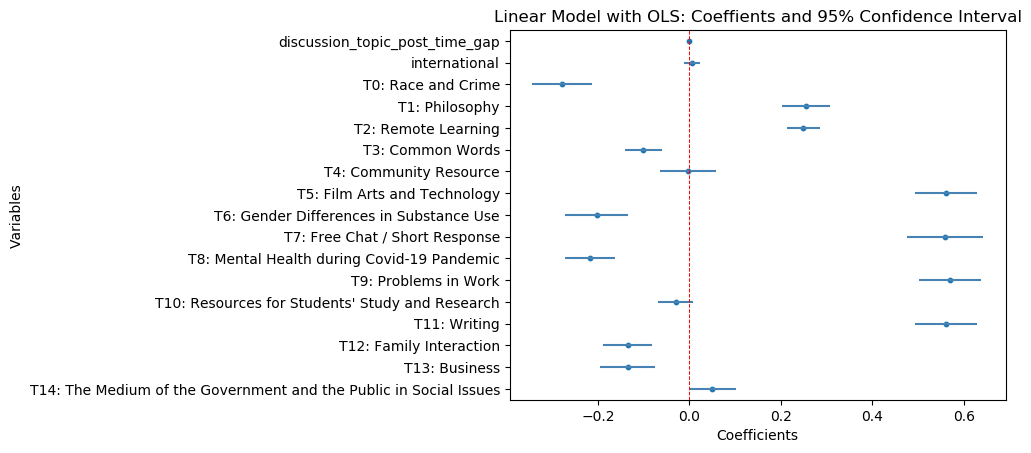

In [130]:
fig, ax = plt.subplots()
coef_err_df.plot(x='varname', y='coef', kind='barh', xerr='error', ax=ax, legend=False, ecolor='steelblue', color='none')
ax.scatter(y=np.arange(coef_err_df.shape[0]), x=coef_err_df['coef'], marker='o', s=10)
ax.axvline(x=0, color='red', linestyle='--', linewidth = 0.7)
ax.set_xlabel('Coefficients')
ax.set_ylabel('Variables')
ax.set_title('Linear Model with OLS: Coeffients and 95% Confidence Interval')
plt.savefig('linear_OLS.png', bbox_inches='tight')
plt.show()

In [105]:
fig.savefig('linear_OLS.png')

In [54]:
pearsonr(df_reply['Analytic'], df_reply['cogproc'])

(-0.33032971491911167, 0.0)

## LDA Models

### Train and Select the best parameters for LDA Mode

In [9]:
import online_discourse_analysis as oda
import numpy as np
import pandas as pd
from joblib import dump, load

In [75]:
# Get some train data
df_train = df.sample(n=int(len(df)*0.2), random_state = 100)

In [77]:
# Clean the data
df_train = oda.discussion_text_clean(df_train)

In [82]:
df_train[['discussion_post_id', 'cleaned_discussion_post']].to_csv('df_train.csv')

In [16]:
doc_set_train = [str(x) for x in list(df_train['cleaned_discussion_post'].values)]
#print(len(doc_set))

# list for tokenized documents
data_words_train = list(oda.sent_to_words(doc_set_train))

# list for lemmatized documents
data_lemmatized_train = oda.lemmatization(data_words_train, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# Create the Document-Word matrix
vectorizer_train = oda.CountVectorizer(analyzer='word', min_df=10, stop_words='english', lowercase=True, token_pattern='[a-zA-Z0-9]{3,}')
data_vectorized_train = vectorizer_train.fit_transform(data_lemmatized_train)

In [ ]:
search_params = {'n_components': [5, 10, 15], 'learning_decay': [.5, .7, .9]}
lda = oda.LatentDirichletAllocation()
model = oda.GridSearchCV(lda, param_grid=search_params)
model.fit(data_vectorized_train)

In [ ]:
oda.allDone()

In [ ]:
print("Best Model's Params: ", model.best_params_)

In [ ]:
print("Best Model's Score: ", model.best_score_)

The best model parameters are: n_components = 15; learning_decay = 0.9

### Run the LDA Model on the whole data

In [10]:
df_LDA = df.loc[:,['discussion_post_id', 'mellon_id', 'canvas_course_id', 'discussion_post_content', 'parent_discussion_post_id']]

In [11]:
len(df_LDA)

1168344

In [12]:
df_run = oda.discussion_text_clean(df_LDA)

In [13]:
df_run

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,parent_discussion_post_id,cleaned_discussion_post
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,NaN,I found the reading for this week's discussion...
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,NaN,This week's reading from Florez discusses what...
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,NaN,Gilliam's reading for this week placed an emph...
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,NaN,I found De Sousa's reading very impactful and ...
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",NaN,a. An example of a monopolistically competitiv...
...,...,...,...,...,...,...
1168339,3976802,174455,36826,<p>I loved your presentation! In terms of bupe...,3958952.0,I loved your presentation! In terms of bupenor...
1168340,3975548,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",3964734.0,"Hello,So the main reason that patients were ab..."
1168341,3982902,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",3967451.0,"Hello,So the main reason that patients were ab..."
1168342,3849145,171666,35994,"<p>According to google, the Universe is 13.8 b...",NaN,"According to google, the Universe is 13.8 bill..."


In [14]:
# Preprocess the data
(vectorizer, data_vectorized) = oda.lda_preprocess(df_run)

In [15]:
# Running the model
(model_new, topic_lst) = oda.lda_model(vectorizer, data_vectorized)

Topic 0: ['black', 'people', 'crime', 'white', 'violence', 'law']
Topic 1: ['think', 'agree', 'make', 'people', 'really', 'good']
Topic 2: ['people', 'community', 'government', 'country', 'health', 'public']
Topic 3: ['social', 'people', 'child', 'life', 'medium', 'family']
Topic 4: ['culture', 'world', 'human', 'example', 'power', 'people']
Topic 5: ['time', 'feel', 'year', 'video', 'friend', 'love']
Topic 6: ['woman', 'man', 'gender', 'drug', 'sex', 'sexual']
Topic 7: ['use', 'company', 'health', 'increase', 'water', 'patient']
Topic 8: ['game', 'art', 'technology', 'problem', 'use', 'people']
Topic 9: ['change', 'covid', 'climate', 'problem', 'pandemic', 'author']
Topic 10: ['student', 'school', 'research', 'study', 'class', 'use']
Topic 11: ['use', 'make', 'film', 'think', 'read', 'really']
Topic 12: ['story', 'different', 'perspective', 'class', 'learn', 'character']
Topic 13: ['money', 'job', 'pay', 'make', 'business', 'cost']


In [16]:
oda.allDone()

In [ ]:
topic_lst

In [84]:
topic_cols = [f'Topic{i}' for i in range(15)]

In [57]:
topic_df = pd.DataFrame(topic_lst, columns=['w1', 'w2', 'w3', 'w4', 'w5', 'w6'])
topic_df['Topic'] = topic_cols
topic_df = topic_df[['Topic', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6']]

In [58]:
topic_df

,Topic,w1,w2,w3,w4,w5,w6
0,Topic0,black,people,white,group,community,american
1,Topic1,think,make,agree,people,really,good
2,Topic2,child,learn,topic,article,school,language
3,Topic3,health,people,social,life,mental,help
4,Topic4,country,change,world,human,power,people
5,Topic5,time,feel,work,video,really,game
6,Topic6,woman,man,gender,drug,sex,sexual
7,Topic7,medium,people,social,use,company,space
8,Topic8,government,increase,cost,policy,rate,public
9,Topic9,author,change,use,make,reader,source


In [59]:
redshift_s3_connect.save_to_s3('topic_df.csv', 'csv', topic_df)

In [60]:
model_new

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.9,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=13, n_jobs=None,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [61]:
# Save the model
dump(model_new, 'LDA_Model.joblib')

['LDA_Model1.joblib']

In [65]:
lda_output = model_new.transform(data_vectorized)
discussion_post[topic_cols] = lda_output

In [66]:
discussion_post

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,discussion_post_updated_at,discussion_post_deleted_at,discussion_post_depth,parent_discussion_post_id,discussion_topic_id,...,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-03-01 07:36:52.865,2022-03-01 07:36:52.865,NaN,1,NaN,679184,...,0.341840,0.000466,0.124435,0.000466,0.000466,0.000466,0.000466,0.110319,0.000466,0.000466
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-10 05:06:35.605,2022-03-10 05:06:35.605,NaN,1,NaN,679190,...,0.167247,0.000699,0.032218,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.025470
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-03 07:35:35.021,2022-03-03 07:35:35.021,NaN,1,NaN,679186,...,0.000496,0.000496,0.000496,0.000496,0.000496,0.000496,0.000496,0.000496,0.000496,0.059389
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-22 07:06:58.18,2022-02-22 07:06:58.18,NaN,1,NaN,679178,...,0.000546,0.000546,0.000546,0.000546,0.000546,0.000546,0.000546,0.076523,0.000546,0.000546
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-23 02:45:06.688,2021-01-23 02:45:06.688,NaN,1,NaN,464333,...,0.002404,0.002404,0.002404,0.002404,0.143624,0.273778,0.002404,0.002404,0.002404,0.002404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168339,3976802,174455,36826,<p>I loved your presentation! In terms of bupe...,2021-04-17 05:14:42.667,2021-04-17 05:14:42.667,NaN,2,3958952.0,537648,...,0.435623,0.004808,0.288862,0.068835,0.004808,0.004808,0.004808,0.004808,0.004808,0.004808
1168340,3975548,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-17 02:40:07.184,2021-04-17 02:40:07.184,NaN,3,3964734.0,537648,...,0.261228,0.003077,0.160479,0.003077,0.003077,0.102013,0.003077,0.106990,0.003077,0.344675
1168341,3982902,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-18 22:13:38.639,2021-04-18 22:13:38.639,NaN,3,3967451.0,537648,...,0.594195,0.002849,0.002849,0.002849,0.002849,0.002849,0.002849,0.112349,0.002849,0.002849
1168342,3849145,171666,35994,"<p>According to google, the Universe is 13.8 b...",2021-03-30 18:10:15.886,2021-03-30 18:10:15.886,NaN,1,NaN,520693,...,0.003077,0.425964,0.003077,0.003077,0.003077,0.453707,0.003077,0.003077,0.003077,0.003077


In [67]:
redshift_s3_connect.save_to_s3('discussion_post_lda.csv', 'csv', discussion_post)

In [68]:
topic_df.to_csv('topic_df.csv')

### Distribution of topics for US and Foreign Students

In [ ]:
import statsmodels.api as sm

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df_lda = redshift_s3_connect.read_from_s3(['discussion_post_lda'], 'csv')

In [11]:
dominant_topic = np.argmax(df_lda[topic_cols].values, axis=1)
df_lda['dominant_topic'] = dominant_topic

In [12]:
df_lda

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,discussion_post_updated_at,discussion_post_deleted_at,discussion_post_depth,parent_discussion_post_id,discussion_topic_id,...,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,dominant_topic
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-03-01 07:36:52.865,2022-03-01 07:36:52.865,NaN,1,NaN,679184,...,0.000404,0.000404,0.000404,0.000404,0.115502,0.000404,0.030095,0.000404,0.218273,3
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-10 05:06:35.605,2022-03-10 05:06:35.605,NaN,1,NaN,679190,...,0.000606,0.000606,0.000606,0.000606,0.000606,0.000606,0.144997,0.000606,0.090478,3
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-03 07:35:35.021,2022-03-03 07:35:35.021,NaN,1,NaN,679186,...,0.000430,0.000430,0.000430,0.000430,0.105291,0.000430,0.102069,0.000430,0.000430,0
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-22 07:06:58.18,2022-02-22 07:06:58.18,NaN,1,NaN,679178,...,0.000473,0.000473,0.000473,0.000473,0.274186,0.237333,0.134962,0.000473,0.000473,10
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-23 02:45:06.688,2021-01-23 02:45:06.688,NaN,1,NaN,464333,...,0.002083,0.002083,0.002083,0.002083,0.002083,0.757963,0.002083,0.214954,0.002083,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168339,3976802,174455,36826,<p>I loved your presentation! In terms of bupe...,2021-04-17 05:14:42.667,2021-04-17 05:14:42.667,NaN,2,3958952.0,537648,...,0.004167,0.004167,0.004167,0.004167,0.004167,0.221790,0.004167,0.267110,0.004167,2
1168340,3975548,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-17 02:40:07.184,2021-04-17 02:40:07.184,NaN,3,3964734.0,537648,...,0.002667,0.002667,0.380535,0.002667,0.002667,0.002667,0.342473,0.002667,0.002667,8
1168341,3982902,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-18 22:13:38.639,2021-04-18 22:13:38.639,NaN,3,3967451.0,537648,...,0.002469,0.002469,0.064244,0.096122,0.090050,0.002469,0.002469,0.002469,0.406295,14
1168342,3849145,171666,35994,"<p>According to google, the Universe is 13.8 b...",2021-03-30 18:10:15.886,2021-03-30 18:10:15.886,NaN,1,NaN,520693,...,0.002667,0.002667,0.072958,0.002667,0.002667,0.002667,0.002667,0.002667,0.002667,4


In [13]:
df_lda.loc[df_lda['citizenship'] != 'Not US Citizen', 'citizenship'] = 'US Student'
df_lda.loc[df_lda['citizenship'] == 'Not US Citizen', 'citizenship'] = 'Foreign Student'

In [20]:
df_lda['citizenship'].unique()

array(['US Student', 'Foreign Student'], dtype=object)

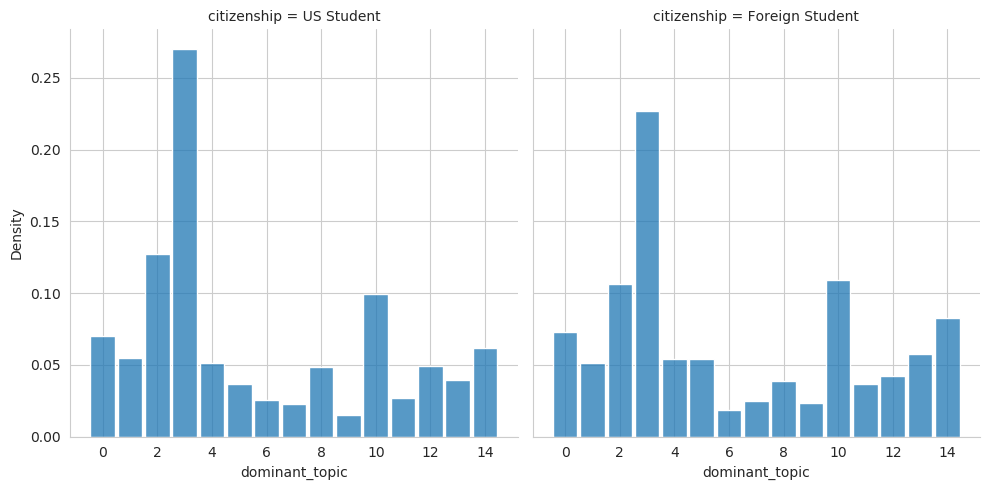

In [79]:
# Plot the distribution of topic for US students
sns.set_style('whitegrid')
g = sns.displot(data=df_lda, x='dominant_topic', col='citizenship', stat="density", 
            common_norm=False, multiple='dodge', discrete=True, shrink=.9)
plt.show(g)

# Remove running query

In [ ]:
redshift_s3_connect.view_running_sql_commands()

In [ ]:
pid = 'pid'
redshift_s3_connect.cancel_sql_command(pid)